# The Graph
The underlying architecture used by Keisler 2022 is that of a message-passing Graph Neural Network ([Battaglia et al. 2018](    
https://doi.org/10.48550/arXiv.1806.01261), [Pfaff et al. 2022](https://arxiv.org/abs/2010.03409)), 
where phyiscal information at high resolution is transfered/mapped to a lower-resolution abstract space. Here the information is processed, after which the result is mapped back to the high resolution physical space to provide the forecast.  
- The mapping from the **physical space** to the **abstract representation** (often called the latent space) is done by the **Encoder**
- The processing in the **latent space** is done by the **Processor**
- The mapping from the **latent space** back to the physical space is done by the **Decoder**

The collection of connections through which information can flow:
- from the data grid to processor grid
- between the points during the processing 
- back to the decoder,
is called **the graph**

In [1]:
import yaml
from anemoi.datasets import open_dataset
import anemoi.graphs.nodes as nodes
import anemoi.graphs.edges as edges
import anemoi.graphs.nodes.attributes as node_attributes
import anemoi.graphs.edges.attributes as edge_attributes
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

## Data Grid
In the physical space the data lives on the 2D - model grid. In our case this is (see previous chapter) a 1&deg; x 1&deg;  lon-lat grid.
We can visualize this grid using the previously built `anemoi-dataset`

In [2]:
dataset_path = "datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr"
ds = open_dataset(dataset_path)

The longitudes and latitudes of the gridpoints can be accessed trought the `longitudes` and `latitudes` attributes.
The 1&deg; x 1&deg; resolution is too fine to clearly visualize the gridoints globally so we focus on an reduced area.

Number of grid-points or data nodes: 65160


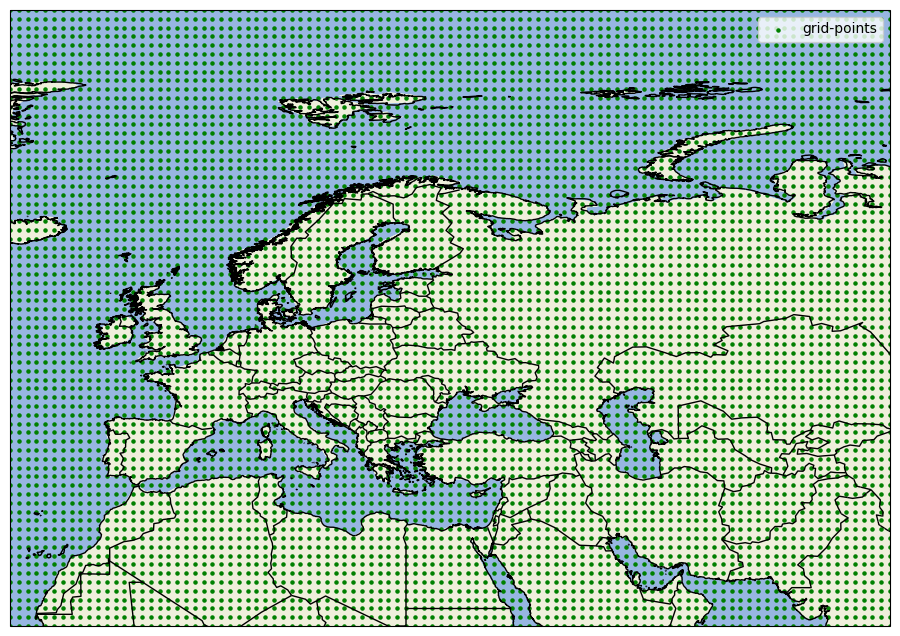

In [3]:
print("Number of grid-points or data nodes:", len(ds.latitudes))

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
ax.scatter(ds.longitudes, ds.latitudes, s=5, c="green", label="grid-points")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines(resolution="10m")
ax.set_extent([-20,80,20,90])
_ = ax.legend(loc="upper right")



In the Machine Learning world these grid points are typically referred to as **data nodes**

# Processor grid
The choice of lower-resolution grid used in the Processor is open. A popular choice is the icosahedron grid.  
This grid is defined by representing the sphere by hexagons or triangles. 
At the coarsest level (i.e. refinement level or resolution 0),  
the hexagonal refined icosahedral grid represents the earth sphere with 122 grid points or nodes.

In Keisler 2022, a refinement level of 2 is chosen, resulting in 5882 points or processor nodes. 

This hexagonal refined icosahedral grid is supported by `anemoi-graphs` and the corresponding grid points can be generated.

In [4]:
from anemoi.graphs.generate.hex_icosahedron import create_hex_nodes

In [5]:
_, coords, ordering = create_hex_nodes(resolution=2)
coords = np.rad2deg(coords)

Number of icosahedral grid-points or processor nodes: 5882


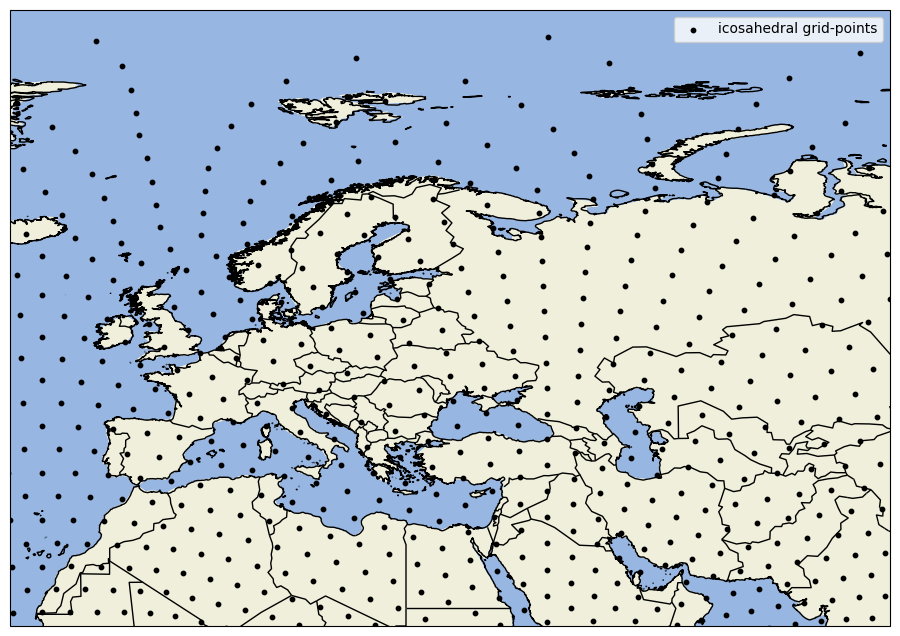

In [6]:
print("Number of icosahedral grid-points or processor nodes:", len(coords))
fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
ax.scatter(coords[:,1], coords[:,0], s=10, c="black", label="icosahedral grid-points")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines(resolution="10m")
ax.set_extent([-20,80,20,90])
_ = ax.legend(loc="upper right")

In the Machine Learning world these grid points in the intermedate state or processorer space are typically referred to as **processor nodes**

## Moving information between grids
The graph message parsing network moves/transfers/maps the physiscal data from the high resolution physical space to a, typically, lower resolution but higher dimensional abstract space. How information can travel between the physical grid and the processor grid and back is determined by defining a **bipartite** (i.e. all connections start in one collection and end in another one) **graph**. 

### Encoding
The transfer from the physical to the abstract space is called the encoding. The flow of information is determined by connecting each processor node with a certain number of data nodes.   
In Keisler 2022, the choice was made to connect each processor node with the 12 nearest data nodes.  
Below it is shown what this looks like for one processor node in the centre of our reduced domain.

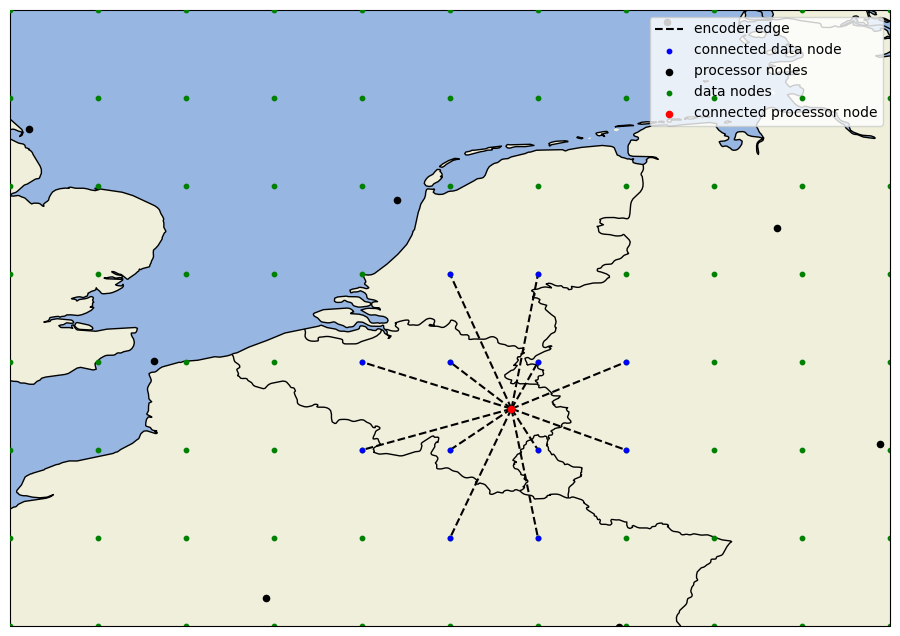

In [7]:
# Set the plotting extent
extent = [0,10,48,55]
# Define the processor grid point in the centre
lon_mid = np.mean(extent[:2])
lat_mid = np.mean(extent[2:4])
i_centre = np.argmin(np.sqrt((coords[:,1]-lon_mid)**2+(coords[:,0]-lat_mid)**2))

# Find its 12 nearest neighbours.
# NOTE: Here the nearest neighbours are determined based on the coordinates, 
#       Ideally one should use the Haverside distance to correctly represent the distances on the globe.
knn = np.argsort(np.sqrt((ds.longitudes-coords[i_centre,1])**2+(ds.latitudes-coords[i_centre,0])**2))[:12]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
# For each data nearest neighbour of the central processor node
for j in knn:
    # Plot the connection (edge) with label for the first one
    if j == knn[0]:
        ax.plot([coords[i_centre,1],ds.longitudes[j]], [coords[i_centre,0], ds.latitudes[j]], c="black",ls="--",zorder=15,label="encoder edge")
        ax.scatter(ds.longitudes[j], ds.latitudes[j], s=10, c="blue", zorder=20, label="connected data node")
    else:
        ax.plot([coords[i_centre,1],ds.longitudes[j]], [coords[i_centre,0], ds.latitudes[j]], c="black",ls="--",zorder=15)
        ax.scatter(ds.longitudes[j], ds.latitudes[j], s=10, c="blue", zorder=20)
    

# Plot all processor nodes
ax.scatter(coords[:,1], coords[:,0], s=20, c="black",label="processor nodes")
# Plot all data nodes
ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes", zorder=15)
# Highlight the centre data node in red
ax.scatter(coords[i_centre,1],coords[i_centre,0],s=20,c="red",label="connected processor node", zorder=20)
# Add map features
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
# set the extent
ax.set_extent(extent)
_ = ax.legend(loc="upper right")


The connections used to encode the information from the data nodes to the processor nodes (dashed lines) are called the **encoder edges**

### Processing
During the processing information is exchanged between the neighbouring processor nodes. In Keisler 2022 each processor node is connected to each 6 nearest neighbours.  
An example of what this looks like is shown here:

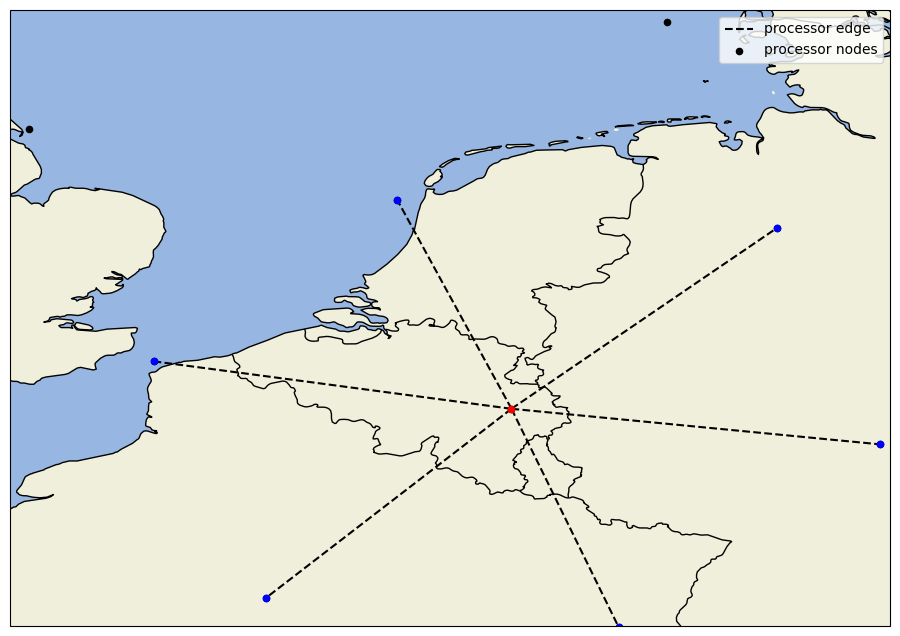

In [8]:
knn = np.argsort(np.sqrt((coords[:,1]-coords[i_centre,1])**2+(coords[:,0]-coords[i_centre,0])**2))[1:7]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

for j in knn:
    if j == knn[0]:
        ax.plot([coords[i_centre,1], coords[j,1]], [coords[i_centre,0], coords[j,0]], c="black",ls="--",zorder=15,label="processor edge")
    else:
        ax.plot([coords[i_centre,1], coords[j,1]], [coords[i_centre,0], coords[j,0]], c="black",ls="--",zorder=15)
    ax.scatter(coords[j,1], coords[j,0], s=20, c="blue",zorder=15)
ax.scatter(coords[:,1], coords[:,0], s=20, c="black",label="processor nodes")
#ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes")
ax.scatter(coords[i_centre,1],coords[i_centre,0],s=20,c="red",zorder=20)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend()


Similar to the encoder above, these connection (dashed lines) are called the **processor edges**.

### Decoding
Finally, to make a sensible weather prediction, we need to map the information again to the interpretatable atmospheric variables on the higher-resolution grid.  
This is done by moving the information from the processor nodes back to the data nodes, by connection each data node to the 3 nearest processor nodes:

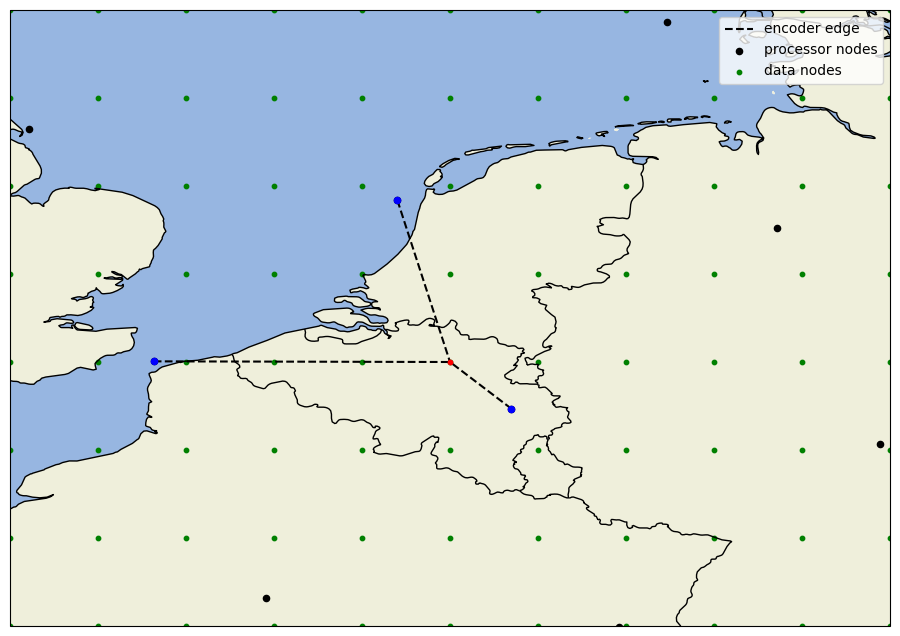

In [9]:
i_centre = np.argmin(np.sqrt((ds.longitudes-lon_mid)**2+(ds.latitudes-lat_mid)**2))
knn = np.argsort(np.sqrt((ds.longitudes[i_centre]-coords[:,1])**2+(ds.latitudes[i_centre]-coords[:,0])**2))[:3]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

for j in knn:
    if j == knn[0]:
        ax.plot([coords[j,1],ds.longitudes[i_centre]], [coords[j,0], ds.latitudes[i_centre]], c="black",ls="--",zorder=15,label="encoder edge")
    else:
        ax.plot([coords[j,1],ds.longitudes[i_centre]], [coords[j,0], ds.latitudes[i_centre]], c="black",ls="--",zorder=15)
    ax.scatter(coords[j,1], coords[j,0], s=20, c="blue", zorder=15)
ax.scatter(coords[:,1], coords[:,0], s=20, c="black",label="processor nodes")
ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes")
ax.scatter(ds.longitudes[i_centre], ds.latitudes[i_centre],s=10,c="red",zorder=20)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend()

Again, these connections are called the **decoder edges**

## Using `anemoi-graphs`
Defining all these nodes and the connections between them to create the graph uses during the message-passing can be automated using [`anemoi-graphs`](https://anemoi.readthedocs.io/projects/graphs).  
Similar to `anemoi-datasets`, `anemoi-graphs` provides a simple high-level interface based on a YAML recipe file, which can be used to build graphs for the input, hidden and output layers. For each layer, the package allows you to:
- Define graph nodes based on coordinates defined in a dataset (anemoi dataset and NPZ) or via algorithmic approaches.
- Define edges (connections between nodes) based on different methods.
- Define attributes of nodes and edges.  

The specification of each layer is defined using a YAML file, which is run via the command-line tool. The command-line tool allows you to quickly create graphs, for example:
```bash
anemoi-graphs create recipe.yaml graph.pt
```


### The `YAML` recipe file
The recipe files exist out of 2 main components and is organized as a python nested dictionary:
1. **Nodes**, defining the different nodes in the graph. Each entry here is another dictionary where the keys are the names of the sets of nodes that will later be used to build the connections. Each corresponding value defines the nodes configuration and must include a node_builder section describing how to define the nodes.
2. **Edges**, defining the connections between the different nodes. Connections are created independently for each *(source name, target name)* pair specified and should enter the dictionary entry as a list. 

In [10]:
# Define the main keys of the graph-recipe
recipe_keys = [
    "nodes",
    "edges",
]
# Build the recipe skeleton
recipe = dict.fromkeys(recipe_keys)

# Different node-types are defined as entries to a dictionary
recipe["nodes"] = dict()

# Different edge-types are defined through elements in a list
recipe["edges"] = list()

recipe

{'nodes': {}, 'edges': []}

### Defining nodes
`anemoi-graphs` can build nodes in many different ways. As explained above, nodes can be build based on the grid points of a specific dataset or can be build using algorithmic approaches.  
An overview of the different node builders available is shown below and more information about them can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/node_coordinates.html).

In [11]:
print("Possible node builders are:")
for builder in nodes.__all__:
    print(f"  - {builder}")


Possible node builders are:
  - AnemoiDatasetNodes
  - ZarrDatasetNodes
  - NPZFileNodes
  - TriNodes
  - HexNodes
  - HEALPixNodes
  - LatLonNodes
  - LimitedAreaHEALPixNodes
  - LimitedAreaNPZFileNodes
  - LimitedAreaTriNodes
  - LimitedAreaHexNodes
  - ReducedGaussianGridNodes
  - StretchedTriNodes
  - ICONMultimeshNodes
  - ICONCellGridNodes
  - ICONNodes
  - TextNodes
  - XArrayNodes


In Keisler 2022, two types of nodes are defined.  

1. The **data nodes**.   
These nodes coincide with the grid points of our data. To derive the data nodes from our previously built `anemoi-dataset` the `node_builder` can be provided with  anemoi-graphs's `AnemoiDatasetNodes` and the path of our dataset:

In [12]:
# Define the data nodes
data_nodes = {
    "node_builder": {
        "_target_": "anemoi.graphs.nodes.AnemoiDatasetNodes",
        "dataset": dataset_path,
    },
}

# Add them the the nodes section of the recipe
recipe["nodes"]["data"] = data_nodes
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}}},
 'edges': []}

2. The **processor** nodes.  
These nodes define the *lower*-resolution nodes used by the processor part of the network. Keisler 2022 uses the nodes of a sphere represented as hexagonal refined icosahedral with refinement level 2. To derive these nodes the `node_builder` can be provided with  anemoi-graphs's `HexNodes` and the refinement level:

In [13]:
# Define the processor nodes
processor_nodes = {
    "node_builder": {
        "_target_": "anemoi.graphs.nodes.HexNodes",
        "resolution": 2,
    }
}

# Add them to the nodes section of the recipe
recipe["nodes"]["processor"] = processor_nodes
recipe


{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': []}

### Defining Edges
`anemoi-graphs` can connect nodes using multiple algoritmic approaches.  
An overview of the different edge builders available is shown below and more information about them can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/edges.html).  
Next to the edge builder itself, anemoi-graph needs to know what the source and target nodes of the edges are. This is specified through the `source_name` and `target_name` entries in the dictionary describing a specific edge type. These names in turn must refer to the names (dictionary-keys) used in the nodes section. In our case either `data` or `processor`

In [14]:
print("Possible edge builders are:")
for builder in edges.__all__:
    print(f"  - {builder}")

Possible edge builders are:
  - KNNEdges
  - CutOffEdges
  - MultiScaleEdges
  - ReversedCutOffEdges
  - ReversedKNNEdges
  - ICONTopologicalProcessorEdges
  - ICONTopologicalEncoderEdges
  - ICONTopologicalDecoderEdges


Let's define the three type of edges used in Keisler 2022:
1. **Encoder edges** connecting the data nodes to the processor nodes using the 12 nearest neighbours. 
In practice this results to defining a dictionary where the `source_name` is set to `data`, the `target_name` is set to `processor` and providing the `edge_builder` with `anmeoi-graphs`' `KNNEdges` and the `num_nearest_neighbours`:

In [15]:
# Define the encoder edges
encoder = {
    "source_name": "data",
    "target_name": "processor",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 12,
    }
}


This dictionary can then be appended to the list of edges:

In [16]:
# Append them to the list of edges
# Note the difference with the nodes, which are added as dictionary entries
recipe["edges"].append(encoder)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}}]}

2. **Processor edges** connecting the a processor nodes to its 6 nearest neighbours:

In [17]:
# Define the processor edges
processor = {
    "source_name": "processor",
    "target_name": "processor",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 6,        
    }
}

# Append them to the list of edges
recipe["edges"].append(processor)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}}]}

3. **Decoder edges** connecting the data nodes to their 3 nearest processor nodes:

In [18]:
# Define the decoder edges
decoder = {
    "source_name": "processor",
    "target_name": "data",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 3
    }
}

# Append them to the list of edges
recipe["edges"].append(decoder)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

### Attributes

Finally, each node and edge can contain additional attributes. These attributes can be usefull for different use-cases, they can be used as additional features for the network (think of edge length end direction) or can be used in the loss function (think of a weight per node) or can be used to mask certain nodes (think of land variables over sea). 

1. **Node attributes**  
An overview of all available node attributes is shown below. More information about the different node attributes can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/node_attributes.html).


In [19]:
print("Available node attributes are:")
for attr in node_attributes.__all__:
    print(f"  - {attr}")
print("")


Available node attributes are:
  - GridsMask
  - SphericalAreaWeights
  - PlanarAreaWeights
  - UniformWeights
  - CutOutMask
  - MaskedPlanarAreaWeights
  - NonmissingAnemoiDatasetVariable
  - BooleanAndMask
  - BooleanNot
  - BooleanOrMask
  - CosineLatWeightedAttribute
  - IsolatitudeAreaWeights



In Keisler 2022, the loss is averaged over all grid point by scaling it using a weight proporational to each grid point's area.  
In a regular lat-lon grid as used here, this is equivalent to weighing each pixel by the *cosine* of its latitude. 
To achieve this, an additional `attributes` key can be provided to the data nodes entry in the recipe:

In [20]:
# Create the attributes entry for the data nodes
recipe["nodes"]["data"]["attributes"] = dict()
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

and the attributes dictionary can be populated by the different `anemoi-graph` node attributes. In our case, the `CosineLatWeightedAttribute` is used.  
The attribute can then later be used by refering to the key name (here `weights`):

In [21]:
# Define the weight attribute
weight_attribute = {
    "_target_": "anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute",
    "norm": "unit-max"
}

# Add it to the attributes dictionary in the recipe, under the weights key
recipe["nodes"]["data"]["attributes"]["weights"] = weight_attribute
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

2. **Edge attributes**  
The Graph Message-Passing Network, uses information about the edge length and edge direction of the different connections. For this info to be available to the network we need to add it to the edges as attributes. Similarly to the nodes, this can be done by adding an attributes key, holding a dictionary to each edge type:


In [22]:
# For all edges at an attribute entry (dictionary)
for edge_type in recipe["edges"]:
    edge_type["attributes"] = dict()
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12},
   'attributes': {}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6},
   'attributes': {}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3},
   'attributes': {}}]}

Edge length and direction can be calculated using the `anemoi-graphs` `EdgeLength` and `EdgeDirection` edge attributes respectively:

In [23]:
# Define the edge-length attribute
edge_length = {"_target_": "anemoi.graphs.edges.attributes.EdgeLength"}
# Define the edge-direction attribute
edge_direction = {"_target_": "anemoi.graphs.edges.attributes.EdgeDirection"}


These attributes can then be added to the respective edges. Again, the attributes can then be used later using their respective dictionary keys. In this case `edge_length` and `edge_direction`.

In [24]:
# For each edge-type
for edge_type in recipe["edges"]:
    # Add the edge length to the attributes
    edge_type["attributes"]["edge_length"] = edge_length
    # Add the edge direction to the attributes
    edge_type["attributes"]["edge_direction"] = edge_direction

recipe


{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': 'datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12},
   'attributes': {'edge_length': {'_target_': 'anemoi.graphs.edges.attributes.EdgeLength'},
    'edge_direction': {'_target_': 'anemoi.graphs.edges.attributes.EdgeDirection'}}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6},
   'attributes': {'edge_length': {'_target_': 'anemoi.graphs.edges.attributes.EdgeLength'}

Let's see now what the final recipe `yaml` looks like

In [25]:
print(
    yaml.dump(
        recipe,
        default_flow_style=False,
        sort_keys=False
    )
)

nodes:
  data:
    node_builder:
      _target_: anemoi.graphs.nodes.AnemoiDatasetNodes
      dataset: datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr
    attributes:
      weights:
        _target_: anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute
        norm: unit-max
  processor:
    node_builder:
      _target_: anemoi.graphs.nodes.HexNodes
      resolution: 2
edges:
- source_name: data
  target_name: processor
  edge_builder:
    _target_: anemoi.graphs.edges.KNNEdges
    num_nearest_neighbours: 12
  attributes:
    edge_length: &id001
      _target_: anemoi.graphs.edges.attributes.EdgeLength
    edge_direction: &id002
      _target_: anemoi.graphs.edges.attributes.EdgeDirection
- source_name: processor
  target_name: processor
  edge_builder:
    _target_: anemoi.graphs.edges.KNNEdges
    num_nearest_neighbours: 6
  attributes:
    edge_length: *id001
    edge_direction: *id002
- source_name: processor
  target_name: data
  edge_builder:
    _target_: a

As mentioned above, creating the graph with `anemoi-graphs` is done through the Command Line Interface.   
Let's save the recipe as a yaml file:

In [26]:
# Directory where to store the recipe
recipe_dir = "./configs"

# Save the recipe as graph.yaml
recipe_path = os.path.join(recipe_dir,"graph.yaml")
with open(recipe_path, 'w') as file:
    yaml.dump(recipe, file, default_flow_style=False, sort_keys=False)

In [27]:
# Create the directory where the graph will be saved
graph_dir = "./graphs"
os.makedirs(graph_dir, exist_ok=True)

# Set the name for the graph (keisler_graph.pt)
graph_path = os.path.join(graph_dir, "keisler_graph.pt")

### Building the graph
With everything in place, the graph can now be build throught the command line command:

In [28]:
!anemoi-graphs create --overwrite {recipe_path} {graph_path}

2025-10-24 13:25:59 INFO Reading the dataset from datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr.
2025-10-24 13:26:00 INFO Using KNN-Edges (with 12 nearest neighbours) between data and processor.
2025-10-24 13:26:00 WARNING The 'torch-cluster' library is not installed. Installing 'torch-cluster' can significantly improve performance for graph creation. You can install it using 'pip install torch-cluster'.
2025-10-24 13:26:00 INFO Using KNN-Edges (with 6 nearest neighbours) between processor and processor.
2025-10-24 13:26:00 WARNING The 'torch-cluster' library is not installed. Installing 'torch-cluster' can significantly improve performance for graph creation. You can install it using 'pip install torch-cluster'.
2025-10-24 13:26:00 INFO Using KNN-Edges (with 3 nearest neighbours) between processor and data.
2025-10-24 13:26:00 WARNING The 'torch-cluster' library is not installed. Installing 'torch-cluster' can significantly improve performance for graph creation. Yo

### Inspecting the graph
Once the graph is built, the graph can be inspected both through its statistics as visually. 
This can be done using the `inspect` command, which will print out some statistics and create interactive plots in the specified directory.

In [29]:
# Inspect the graph, plots will be saved in the specified directory (here: graph_dir)
!anemoi-graphs inspect {graph_path} {graph_dir}


📦 Path       : ./graphs/keisler_graph.pt
💽 Size       : 6.5 MiB (6856096)

🪩  Nodes summary

   Nodes name │ Num. nodes │ Attributes │ Attribute dim │ Min. latitude │ Max. latitude │ Min. longitude │ Max. longitude
   ───────────┼────────────┼────────────┼───────────────┼───────────────┼───────────────┼────────────────┼───────────────
   data       │      65160 │    weights │             1 │           -90 │            90 │              0 │            359
   processor  │       5882 │            │             0 │      -89.2415 │       89.2415 │       -179.975 │        179.939
   ───────────┴────────────┴────────────┴───────────────┴───────────────┴───────────────┴────────────────┴───────────────


🌐  Edges summary

   Source    │ Target    │ Num. edges │ Isolated Source │ Isolated Target │ Attribute dim │                          Attributes
   ──────────┼───────────┼────────────┼─────────────────┼─────────────────┼───────────────┼────────────────────────────────────
   data      │ proce

Let's take a look at the generated files:

In [30]:
graph_dir_content = os.listdir(graph_dir)
file_types = {
    "graph-file": ".pt",
    "statistics": ".png",
    "interactive plots": ".html",
}

for type, ext in file_types.items():
    files = [file for file in graph_dir_content if file.endswith(ext)]
    print(f"The graph directory contains following {type}:")
    for file in files:
        print(f" - {file}")

The graph directory contains following graph-file:
 - keisler_graph.pt
The graph directory contains following statistics:
 - distribution_edge_attributes.png
 - distribution_node_attributes.png
 - distribution_node_adjancency.png
The graph directory contains following interactive plots:
 - processor_to_data.html
 - isolated_nodes.html
 - processor_to_processor.html
 - data_to_processor.html


To check *quality* of the graph, it can be usefull to inspect the edge attributes distribution:

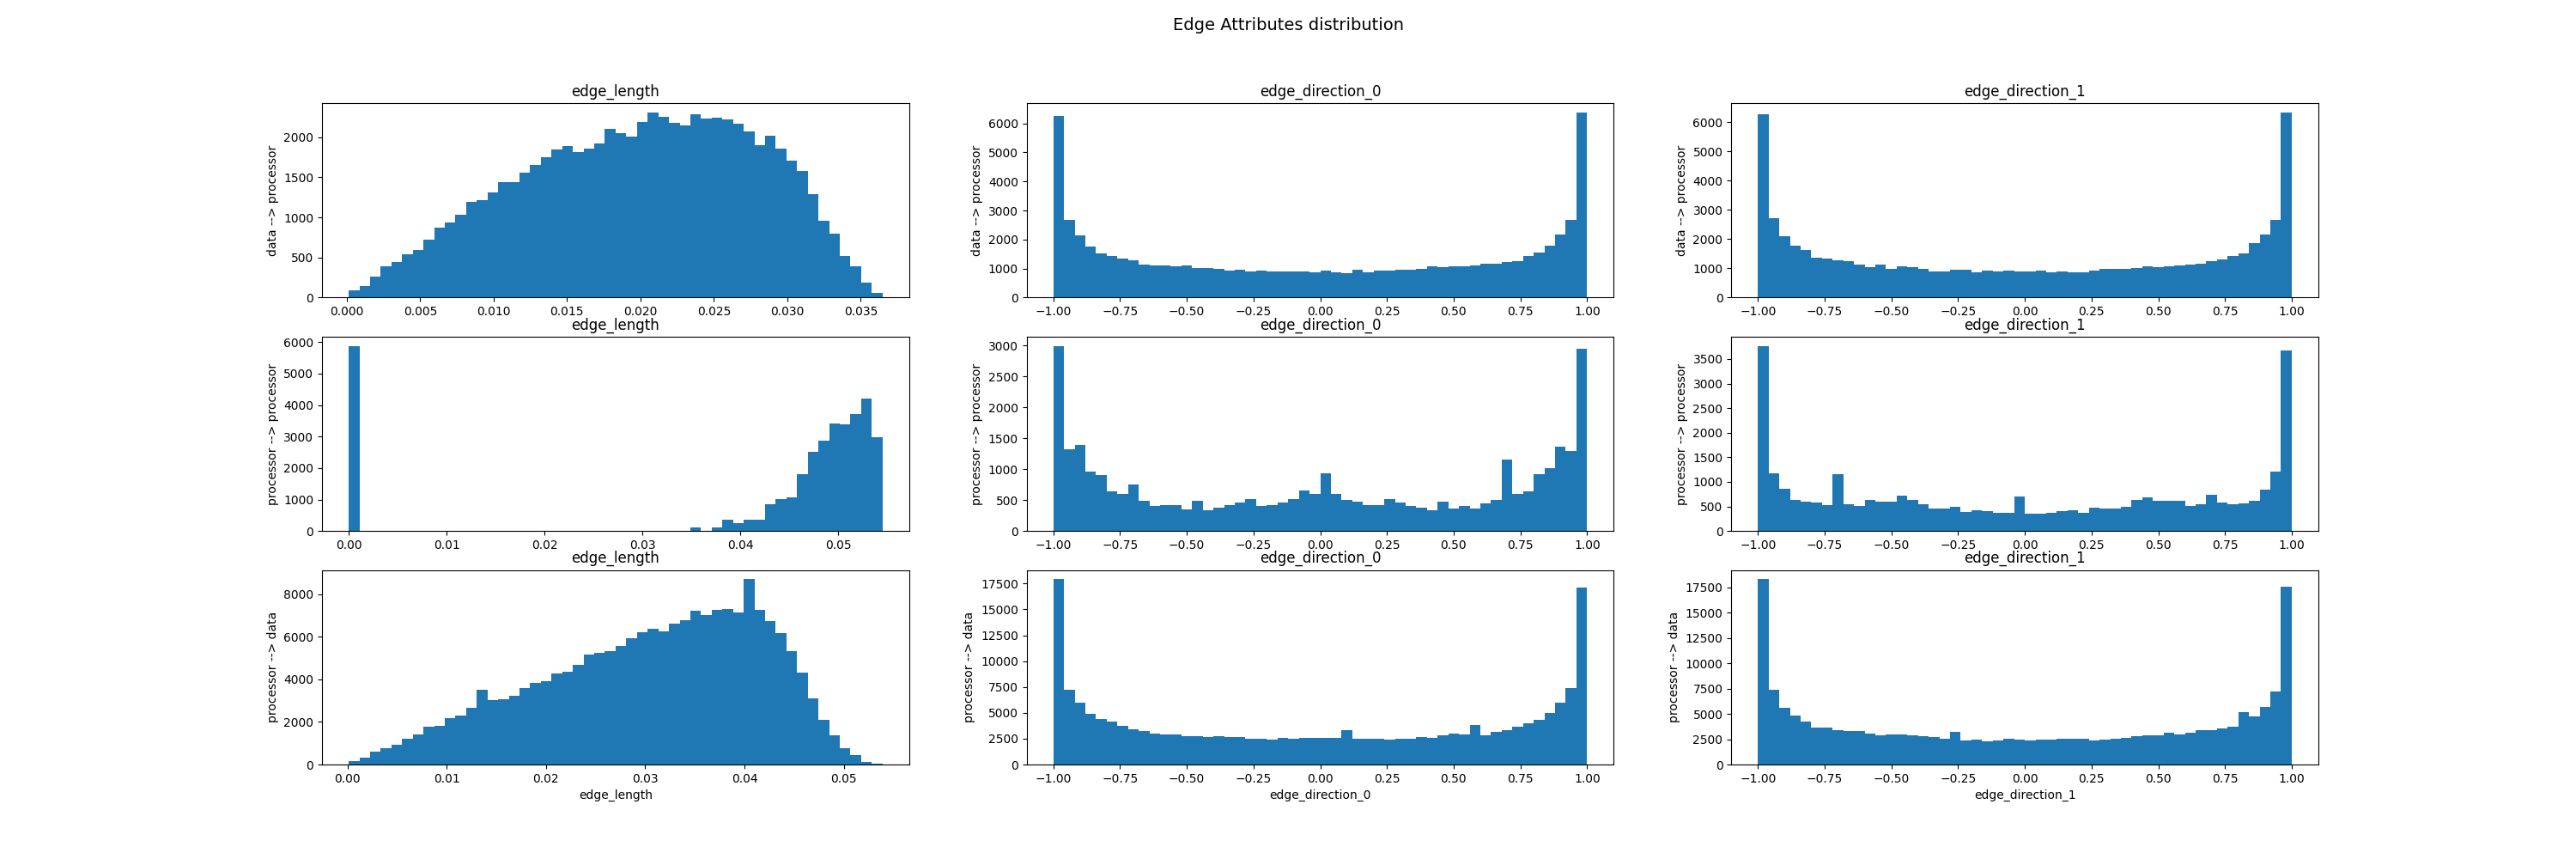

In [31]:
from IPython.display import Image
Image(filename=os.path.join(graph_dir,"distribution_edge_attributes.png"))

Typically, the resulting distributions should be reasonably flat without too many outliers. 
One can see for instance that in our case there are around 5800 processor edges with a very small edge length. 
These can be identified as the processor edges that connect the processor nodes to itself (there are 5882 of these).

## The graph-file
The graph is stored as a [pytorch-geomteric `HeteroData`](https://pytorch-geometric.readthedocs.io/en/2.5.0/generated/torch_geometric.data.HeteroData.html#torch_geometric.data.HeteroData) object and can thus be loaded with `torch.load`

In [32]:
import torch
graph = torch.load(
    graph_path, 
    weights_only=False # We are not leading a model
)


An `HeteroData` object mimics the behaviour of a regular nested python dictionary with added functionality for analyzing graph structures.

In [33]:
print(graph)

HeteroData(
  data={
    x=[65160, 2],
    node_type='AnemoiDatasetNodes',
    weights=[65160, 1],
  },
  processor={
    x=[5882, 2],
    node_type='HexNodes',
  },
  (data, to, processor)={
    edge_index=[2, 70584],
    edge_type='KNNEdges',
    edge_length=[70584, 1],
    edge_direction=[70584, 2],
  },
  (processor, to, processor)={
    edge_index=[2, 35292],
    edge_type='KNNEdges',
    edge_length=[35292, 1],
    edge_direction=[35292, 2],
  },
  (processor, to, data)={
    edge_index=[2, 195480],
    edge_type='KNNEdges',
    edge_length=[195480, 1],
    edge_direction=[195480, 2],
  }
)


In [34]:
print(f"The graph has a total of {graph.num_nodes} nodes, with node types:")
for node in graph.node_types:
    print(f" - {node}: {graph.get_node_store(node)["node_type"]} with {graph.num_node_features[node]} features")
print("and following edge types:")
for edge in graph.edge_types:
    print(f" - {edge}: {graph.get_edge_store(*edge)["edge_type"]}")

The graph has a total of 71042 nodes, with node types:
 - data: AnemoiDatasetNodes with 2 features
 - processor: HexNodes with 2 features
and following edge types:
 - ('data', 'to', 'processor'): KNNEdges
 - ('processor', 'to', 'processor'): KNNEdges
 - ('processor', 'to', 'data'): KNNEdges


As seen above, the data and processor nodes have 2 features.  
These are the latitude and longitude of the nodes and can be accessed throught the `x` key in the respective node dictionaries:

In [35]:
i = 0
for node in graph.node_types:
    features = graph[node]["x"]
    print(f"There are {features.shape[0]} {node} nodes with each {features.shape[1]} features")
    print(f"{node} node {i} has:")
    print(f" - Latitude: {np.rad2deg(features[i,0])}") # anemoi-graphs saves latitudes and longitudes as radians!
    print(f" - Longitude: {np.rad2deg(features[i,1])}")

There are 65160 data nodes with each 2 features
data node 0 has:
 - Latitude: -90.0
 - Longitude: 0.0
There are 5882 processor nodes with each 2 features
processor node 0 has:
 - Latitude: 89.24151611328125
 - Longitude: -35.53231430053711


The start and end points of a certain edge type are stored under their respective `edge_index` key.
The resulting array is structured as follows:
- the last dimension contains all the edges
- the first dimension contains the index of source  node (index 0) and the index of the target node (index 1)

In [36]:
edge = ("data", "to", "processor")
for i in range(13):
    print(f"{edge} edge {i} connects " + 
          f"{edge[0]} node {graph[edge]["edge_index"][0,i]} to " +
          f"{edge[-1]} node {graph[edge]["edge_index"][-1,i]}")


('data', 'to', 'processor') edge 0 connects data node 58823 to processor node 0
('data', 'to', 'processor') edge 1 connects data node 59004 to processor node 0
('data', 'to', 'processor') edge 2 connects data node 58642 to processor node 0
('data', 'to', 'processor') edge 3 connects data node 59185 to processor node 0
('data', 'to', 'processor') edge 4 connects data node 58461 to processor node 0
('data', 'to', 'processor') edge 5 connects data node 59366 to processor node 0
('data', 'to', 'processor') edge 6 connects data node 58280 to processor node 0
('data', 'to', 'processor') edge 7 connects data node 59547 to processor node 0
('data', 'to', 'processor') edge 8 connects data node 58099 to processor node 0
('data', 'to', 'processor') edge 9 connects data node 59728 to processor node 0
('data', 'to', 'processor') edge 10 connects data node 57918 to processor node 0
('data', 'to', 'processor') edge 11 connects data node 59909 to processor node 0
('data', 'to', 'processor') edge 12 co

With the structure of the `HeteroData` graph now clear, a similar figure as above of encoder edges can now be constructed

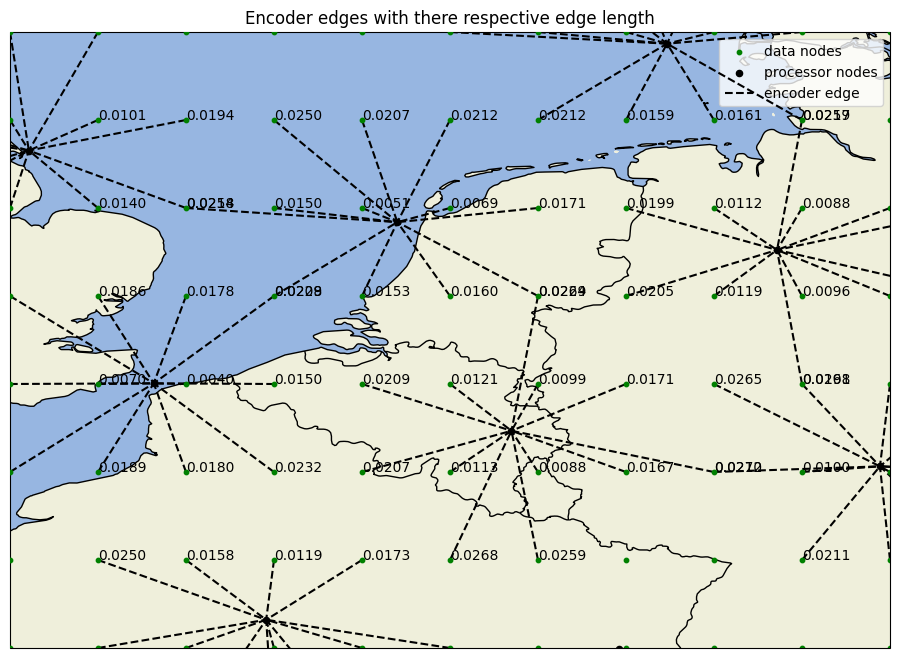

In [37]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

# Make sure all longitudes are mapped from [0, 360] to [-180, 180]
data_latlons = (np.rad2deg(graph["data"]["x"]) + 180 ) % 360 - 180
processor_latlons = (np.rad2deg(graph["processor"]["x"]) + 180 ) % 360 - 180

# Plot the data nodes
ax.scatter(
    data_latlons[:,1],  # longitudes
    data_latlons[:,0], # latitudes 
    s=10, 
    c="green",
    label="data nodes", 
    zorder=20
)

# Plot the processor nodes
ax.scatter(
    processor_latlons[:,1], # longitudes
    processor_latlons[:,0], # latitudes
    s=20, 
    c="black", 
    label="processor nodes", 
    zorder=20
)

encoder_edges = graph[("data","to","processor")]["edge_index"]
# Loop over the edges
for i in range(encoder_edges.shape[1]):
    i_data = encoder_edges[0,i]      # index of the source data node
    i_processor = encoder_edges[1,i] # index of the target processor node

    # lat-lon of the soure data node
    lat_data, lon_data = data_latlons[i_data,:]
    # lat-lon of the target processor node
    lat_proc, lon_proc = processor_latlons[i_processor,:]
    
    # helper lat-lon for the label 
    lat_text, lon_text = (lat_data, lon_data)

    # Only plot edges within the extent
    if lon_proc > 0 and lon_proc < 10 and lat_proc > 48 and lat_proc < 55:                                 
        # Plot the edge
        im = ax.plot(
            [lon_data, lon_proc],
            [lat_data, lat_proc],
            c="black",
            ls="--",
            zorder=15
        )
        if lon_text > 0 and lon_text < 10 and lat_text > 48 and lat_text < 55:
            # Plot the edge_length attribute
            ax.text(x=lon_text,y=lat_text,s=f"{graph[("data","to","processor")]["edge_length"][i][0]:.4f}")
im[0].set_label("encoder edge")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend(loc="upper right")
_ = ax.set_title("Encoder edges with there respective edge length")

If you look closely you can see a small difference with the plot made above.  
This is because `anemoi-graphs` calculates the nearest neighbours using the correct haversine-distance, while above the distance was computed in the plate carree projections.